In [1]:
!pip install kagglehub timm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 11.3 MB/s eta 0:00:00


In [2]:
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import f1_score
import timm
import cv2
from sklearn.model_selection import train_test_split
import kagglehub

path = kagglehub.dataset_download("sanikatiwarekar/deep-fake-detection-dfd-entire-original-dataset")
print("Path to dataset files:", path)

100%|██████████| 22.5G/22.5G [13:23<00:00, 30.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sanikatiwarekar/deep-fake-detection-dfd-entire-original-dataset/versions/1


In [3]:
# Dataset paths
#DATASET_PATH = '/kaggle/input/deep-fake-detection-dfd-entire-original-dataset'
DATASET_PATH = '/root/.cache/kagglehub/datasets/sanikatiwarekar/deep-fake-detection-dfd-entire-original-dataset/versions/1'
REAL_VIDEOS_PATH = os.path.join(DATASET_PATH, 'DFD_original sequences')
FAKE_VIDEOS_PATH = os.path.join(DATASET_PATH, 'DFD_manipulated_sequences', 'DFD_manipulated_sequences')

FRAME_SAVE_DIR = "/content/frames"
os.makedirs(FRAME_SAVE_DIR, exist_ok=True)
# Helper to extract frames from selected videos
def extract_frames(video_list, label, frame_dir, frames_per_video=5):
    for vid_path in video_list:
        cap = cv2.VideoCapture(vid_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_idxs = np.linspace(0, total_frames - 1, frames_per_video, dtype=int)
        vid_name = os.path.splitext(os.path.basename(vid_path))[0]
        for idx in frame_idxs:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            success, frame = cap.read()
            if success:
                frame_filename = f"{vid_name}_{idx}_{label}.jpg"
                cv2.imwrite(os.path.join(frame_dir, frame_filename), frame)
        cap.release()

# List available videos
real_videos = [os.path.join(REAL_VIDEOS_PATH, f) for f in os.listdir(REAL_VIDEOS_PATH) if f.endswith('.mp4')]
fake_videos = [os.path.join(FAKE_VIDEOS_PATH, f) for f in os.listdir(FAKE_VIDEOS_PATH) if f.endswith('.mp4')]

# Select 100 real and 100 fake videos
real_selected = random.sample(real_videos, 50)
fake_selected = random.sample(fake_videos, 50)

# Extract frames
extract_frames(real_selected, label="real", frame_dir=FRAME_SAVE_DIR)
extract_frames(fake_selected, label="fake", frame_dir=FRAME_SAVE_DIR)


In [4]:
# Create Dataset
class DeepfakeDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        label = 0 if "real" in img_path else 1
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        return img, label

# Train/Val Split
all_frames = [os.path.join(FRAME_SAVE_DIR, f) for f in os.listdir(FRAME_SAVE_DIR)]
train_files, val_files = train_test_split(all_frames, test_size=0.2, stratify=["real" if "real" in f else "fake" for f in all_frames], random_state=42)

# Transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# DataLoaders
train_dataset = DeepfakeDataset(train_files, transform)
val_dataset = DeepfakeDataset(val_files, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [16]:
class EfficientNetB0_FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, features_only=True)

    def forward(self, x):
        features = self.backbone(x)[-1]  # Last feature map
        return features

class PretrainedTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = timm.create_model('vit_tiny_patch16_224', pretrained=True)

        # EfficientNet outputs 320 channels; ViT expects 192-dim tokens
        self.proj = nn.Linear(320, self.vit.embed_dim)  # 320 → 192

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.flatten(2).permute(0, 2, 1)  # [B, 49, 320]
        x = self.proj(x)                  # [B, 49, 192]

        cls_token = self.vit.cls_token.expand(B, -1, -1)  # [B, 1, 192]
        x = torch.cat((cls_token, x), dim=1)              # [B, 50, 192]
        x = x + self.vit.pos_embed[:, :x.size(1), :]      # Add position embeddings
        x = self.vit.blocks(x)                            # Transformer layers
        return x[:, 0]                                    # CLS token output

class EfficientViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = EfficientNetB0_FeatureExtractor()
        self.transformer = PretrainedTransformer()  # no emb_size argument!
        self.classifier = nn.Linear(192, 2)         # NOTE: output is now 192, not 320

    def forward(self, x):
        features = self.feature_extractor(x)  # [B, 320, 7, 7]
        out = self.transformer(features)      # [B, 192]
        out = self.classifier(out)
        return out

In [6]:
class EfficientNetV2Small(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.backbone = timm.create_model('efficientnetv2_rw_s', pretrained=True, num_classes=0)
        self.classifier = nn.Linear(self.backbone.num_features, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        return self.classifier(x)

In [7]:
class ViT_Model(torch.nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.model = timm.create_model('deit_small_patch16_224', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

In [19]:
models_dict = {
    "EfficientNetV2Small": EfficientNetV2Small(),
    "ViT_Model": ViT_Model(),
    "EfficientViT": EfficientViT()
}

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Training function
def train_model(model, name, num_epochs=10):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_accuracies, val_f1s = [], [], []

    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss/len(train_loader))

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_acc = np.mean(np.array(all_preds) == np.array(all_labels))
        val_f1 = f1_score(all_labels, all_preds, zero_division=1)

        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        print(f"{name} - Epoch {epoch+1}: Loss {running_loss/len(train_loader):.4f}, Val Acc {val_acc:.4f}, Val F1 {val_f1:.4f}")

    training_time = time.time() - start_time

    return train_losses, val_accuracies, val_f1s, training_time

# Train all models
results = {}

for model_name, model_obj in models_dict.items():
    print(f"Training {model_name}...")
    train_loss, val_acc, val_f1, duration = train_model(model_obj, model_name)
    results[model_name] = {
        "loss": train_loss,
        "accuracy": val_acc,
        "f1": val_f1,
        "time": duration
    }

Training EfficientNetV2Small...
EfficientNetV2Small - Epoch 1: Loss 0.6659, Val Acc 0.6000, Val F1 0.6000
EfficientNetV2Small - Epoch 2: Loss 0.4921, Val Acc 0.7000, Val F1 0.6939
EfficientNetV2Small - Epoch 3: Loss 0.3503, Val Acc 0.8400, Val F1 0.8367
EfficientNetV2Small - Epoch 4: Loss 0.2208, Val Acc 0.8500, Val F1 0.8515
EfficientNetV2Small - Epoch 5: Loss 0.1675, Val Acc 0.9000, Val F1 0.9000
EfficientNetV2Small - Epoch 6: Loss 0.1059, Val Acc 0.9100, Val F1 0.9126
EfficientNetV2Small - Epoch 7: Loss 0.0685, Val Acc 0.9300, Val F1 0.9293
EfficientNetV2Small - Epoch 8: Loss 0.0921, Val Acc 0.9100, Val F1 0.9109
EfficientNetV2Small - Epoch 9: Loss 0.0714, Val Acc 0.9100, Val F1 0.9109
EfficientNetV2Small - Epoch 10: Loss 0.0871, Val Acc 0.9000, Val F1 0.8980
Training ViT_Model...
ViT_Model - Epoch 1: Loss 0.6545, Val Acc 0.7100, Val F1 0.6234
ViT_Model - Epoch 2: Loss 0.3589, Val Acc 0.8100, Val F1 0.7654
ViT_Model - Epoch 3: Loss 0.1837, Val Acc 0.8400, Val F1 0.8182
ViT_Model - E

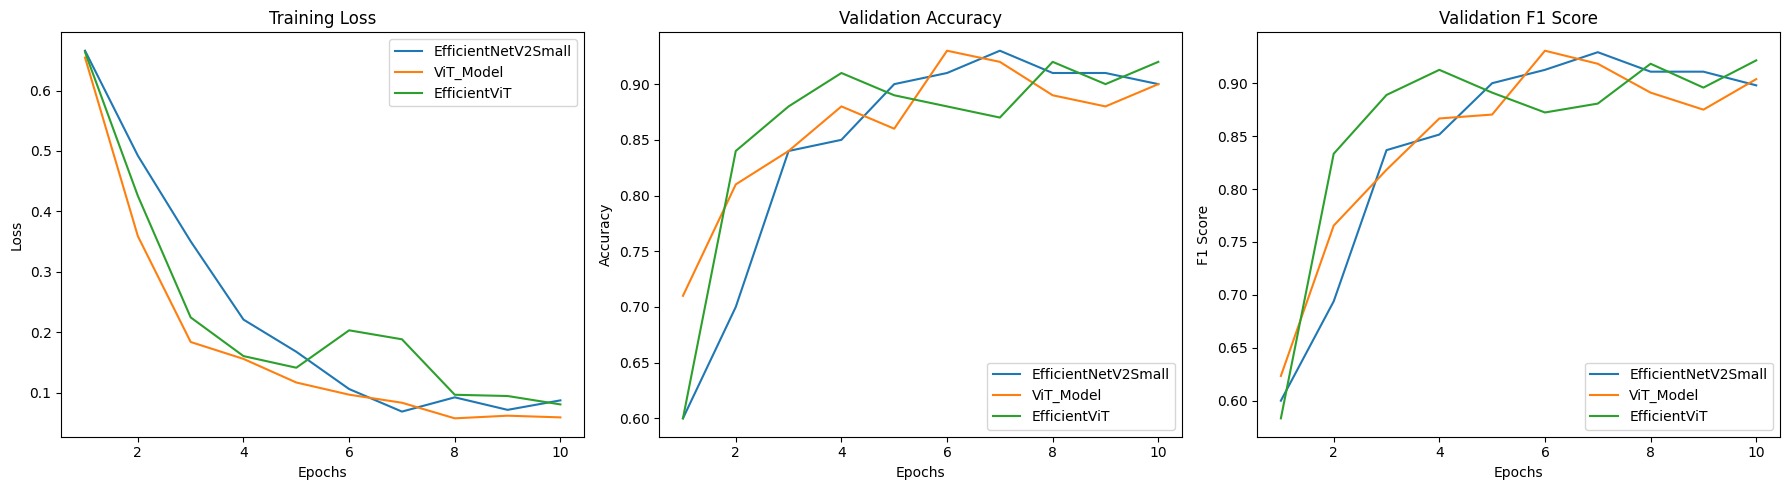

EfficientNetV2Small Training Time: 2556.85 seconds
ViT_Model Training Time: 2333.78 seconds
EfficientViT Training Time: 1224.59 seconds


In [21]:
# Plot
epochs = range(1, 11)

plt.figure(figsize=(18,5))

# Loss
plt.subplot(1,3,1)
for model_name in results.keys():
    plt.plot(epochs, results[model_name]['loss'], label=model_name)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,3,2)
for model_name in results.keys():
    plt.plot(epochs, results[model_name]['accuracy'], label=model_name)
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# F1
plt.subplot(1,3,3)
for model_name in results.keys():
    plt.plot(epochs, results[model_name]['f1'], label=model_name)
plt.title('Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

# Print Training Times
for model_name in results.keys():
    print(f"{model_name} Training Time: {results[model_name]['time']:.2f} seconds")

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)